# Doc 10 - Transfer Learning com DenseNet com congelamento geral

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from PIL import Image
import matplotlib.pylab as plt
import pandas as pd
import os
import shutil
import numpy as np
import seaborn as sns

C:\Users\breno\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1 - Visualização da base de dados

In [2]:
#Função para visualização
def plot_image_counts(folder_path):
    #Contadores pra plotar
    counts = {'actionable': 0, 'benign': 0, 'cancer': 0, 'normal': 0}

    #Vai olhar os folders
    total_images = 0
    for class_name in counts.keys():
        class_path = os.path.join(folder_path, class_name)
        if os.path.exists(class_path):
            class_count = len(os.listdir(class_path))
            counts[class_name] = class_count
            total_images += class_count

    #Cálculo da porcentagem
    percentages = {class_name: count / total_images * 100 for class_name, count in counts.items()}

    #Plot dos gráficos
    plt.figure(figsize=(10, 6))
    plt.bar(percentages.keys(), percentages.values(), color=['blue', 'green', 'red', 'purple'])
    plt.xlabel('Classe')
    plt.ylabel('Porcentagem')
    plt.title('Porcentagem de imagens em cada classe')
    plt.show()

    #Tabelinha
    df = pd.DataFrame({'Quantidade': counts.values(), 'Porcentagem': percentages.values()}, index=counts.keys())
    print("Tabela quantidade-porcentagem:")
    print(df)

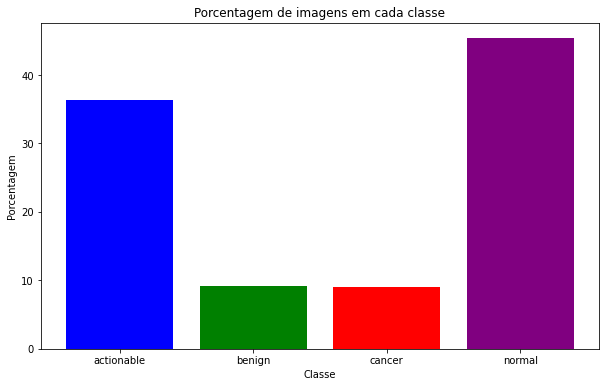

Tabela quantidade-porcentagem:
            Quantidade  Porcentagem
actionable         240    36.308623
benign              61     9.228442
cancer              60     9.077156
normal             300    45.385779


In [18]:
#Test set
folder_path = r'D:\Coisinhas\Coisas_UNB\TCC\resized_paper_dataset\test'
plot_image_counts(folder_path)

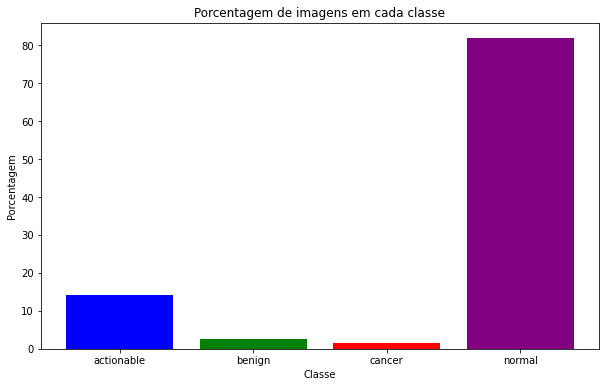

Tabela quantidade-porcentagem:
            Quantidade  Porcentagem
actionable         712    14.180442
benign             124     2.469628
cancer              76     1.513643
normal            4109    81.836288


In [19]:
#Training set
folder_path = r'D:\Coisinhas\Coisas_UNB\TCC\resized_paper_dataset\train'
plot_image_counts(folder_path)

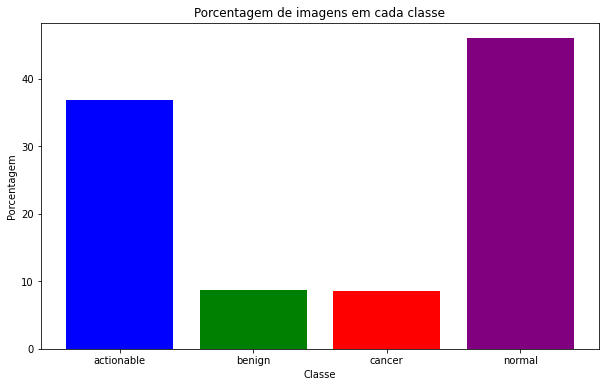

Tabela quantidade-porcentagem:
            Quantidade  Porcentagem
actionable         160    36.781609
benign              38     8.735632
cancer              37     8.505747
normal             200    45.977011


In [20]:
#Validation set
folder_path = r'D:\Coisinhas\Coisas_UNB\TCC\resized_paper_dataset\val'
plot_image_counts(folder_path)

# 2 - Resize das imagens

In [6]:
def resize_images(input_folder, output_folder, target_size):
    #Vai fazer a path ficar igual ao original com test/train/val
    for root, dirs, files in os.walk(input_folder):
        for dir_name in dirs:
            os.makedirs(os.path.join(output_folder, os.path.relpath(root, input_folder), dir_name), exist_ok=True)

    #Resize só se tiver dimensões diferentes
    for root, dirs, files in os.walk(input_folder):
        for file in files:
            if file.endswith(".png"):
                input_path = os.path.join(root, file)
                output_path = os.path.join(output_folder, os.path.relpath(root, input_folder), file)
                
                #Abre a imagem e resize se necessário
                with Image.open(input_path) as img:
                    if img.size != target_size:
                        #Resize
                        img_resized = img.resize(target_size)
                        img_resized.save(output_path)
                    else:
                        #Copia e salva
                        shutil.copyfile(input_path, output_path)

In [7]:
input_folder = r"D:\Coisinhas\Coisas_UNB\TCC\paper_dataset"
output_folder = r"D:\Coisinhas\Coisas_UNB\TCC\resized_paper_dataset"
target_size = (1890, 2457) #Vamos primeiro dar o resize nas imagens que não têm essas dimensões (padronização).
resize_images(input_folder, output_folder, target_size)

In [8]:
#Agora damos um resize de 4 vezes menor em cima do mesmo folder.
target_size = (1890//4, 2457//4)
resize_images(output_folder, output_folder, target_size)

# 3 - Modelo usando DenseNet

In [6]:
#Diretórios
train_dir = r'D:\Coisinhas\Coisas_UNB\TCC\resized_paper_dataset\train'
val_dir = r'D:\Coisinhas\Coisas_UNB\TCC\resized_paper_dataset\test'
test_dir = r'D:\Coisinhas\Coisas_UNB\TCC\resized_paper_dataset\val'

#Set das dimensões
img_width, img_height = 1890//4, 2457//4 
input_shape = (img_width, img_height, 3)

#Batch size
batch_size = 16

#CLasses
num_classes = 4

In [7]:
#Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 5021 images belonging to 4 classes.
Found 661 images belonging to 4 classes.
Found 435 images belonging to 4 classes.


In [8]:
#Transfer learning com a densenet
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(1890//4, 2457//4, 3))

#Congelando os pesos e trocando o último layer para nossas 4 classes
for layer in base_model.layers:
    layer.trainable = False
    
x = Flatten()(base_model.output) 
x = Dense(256, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [9]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 472, 614, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d                │ (None, 478, 620, 3)       │               0 │ input_layer[0][0]          │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 236, 307, 64)      │           9,408 │ zero_padding2d[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 236, 307, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 236, 307, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_1              │ (None, 238, 309, 64)      │               0 │ conv1_relu[0][0]           │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1 (MaxPooling2D)          │ (None, 118, 154, 64)      │               0 │ zero_padding2d_1[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_bn             │ (None, 118, 154, 64)      │             256 │ pool1[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_relu           │ (None, 118, 154, 64)      │               0 │ conv2_block1_0_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 118, 154, 128)     │           8,192 │ conv2_block1_0_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 118, 154, 128)     │             512 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 118, 154, 128)     │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 118, 154, 32)      │          36,864 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_concat           │ (None, 118, 154, 96)      │               0 │ pool1[0][0],               │
│ (Concatenate)                 │                           │               

 Total params: 76,769,092 (292.85 MB)

 Trainable params: 69,731,588 (266.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [10]:
#Compilar o modelo
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
#Setup do early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

In [12]:
#Treinamento
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[early_stopping])

Epoch 1/100


C:\Users\breno\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


314/314 ━━━━━━━━━━━━━━━━━━━━ 2397s 8s/step - accuracy: 0.6738 - loss: 18.0373 - val_accuracy: 0.4690 - val_loss: 5.0049
Epoch 2/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 2390s 8s/step - accuracy: 0.7770 - loss: 0.9891 - val_accuracy: 0.4599 - val_loss: 2.8307
Epoch 3/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 2379s 8s/step - accuracy: 0.8402 - loss: 0.4370 - val_accuracy: 0.4584 - val_loss: 2.7242
Epoch 4/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 2387s 8s/step - accuracy: 0.8877 - loss: 0.3058 - val_accuracy: 0.4614 - val_loss: 3.0205
Epoch 5/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 2382s 8s/step - accuracy: 0.9037 - loss: 0.2627 - val_accuracy: 0.4554 - val_loss: 5.5929
Epoch 6/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 2388s 8s/step - accuracy: 0.8841 - loss: 0.3302 - val_accuracy: 0.4493 - val_loss: 3.5441
Epoch 7/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 2388s 8s/step - accuracy: 0.9367 - loss: 0.1756 - val_accuracy: 0.4281 - val_loss: 3.9055
Epoch 8/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 2410s 8s/step - accuracy: 0.9128 - loss: 0.2340 - val

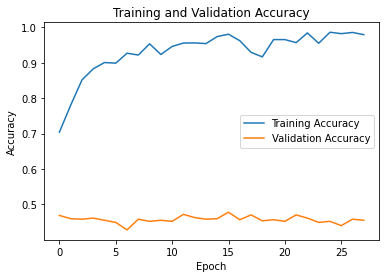

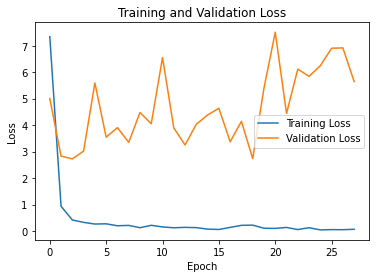

In [13]:
#Analise da precisao do treinamento e validacao
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Analise da loss do treinamento e validacao
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

28/28 ━━━━━━━━━━━━━━━━━━━━ 181s 6s/step - accuracy: 0.4638 - loss: 2.6381
Test Accuracy: 46.21%
Test Loss: 2.5161


In [15]:
predictions = model.predict(test_generator)

#Pega os indices dos labels que foram 'predicted'
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels

28/28 ━━━━━━━━━━━━━━━━━━━━ 187s 6s/step


array([3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 0, 3, 0, 3, 0, 3, 3, 3, 3, 3, 0,
       0, 3, 3, 3, 3, 3, 3, 0, 3, 0, 3, 3, 0, 3, 3, 3, 3, 3, 3, 1, 3, 3,
       3, 3, 3, 3, 0, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3,
       0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 0, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 0, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 0, 0, 0,
       3, 3, 0, 3, 3, 3, 0, 3, 0, 3, 3, 0, 3, 3, 3, 3, 0, 3, 3, 3, 0, 0,
       3, 3, 0, 3, 3, 0, 0, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 0, 3,

In [16]:
#Pega os indices corretos
true_labels = test_generator.labels
true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

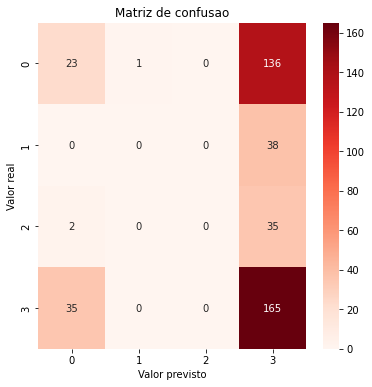

In [17]:
confusion = confusion_matrix(true_labels, predicted_labels)


plt.figure(figsize=(6, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds', xticklabels=range(4), yticklabels=range(4))
plt.xlabel('Valor previsto')
plt.ylabel('Valor real')
plt.title('Matriz de confusao')
plt.show()

Segue não aprendendo muito bem, mas agora parece conseguir colocar algumas das imagens no grupo "actionable".